<a href="https://colab.research.google.com/github/theaok/leonieAgency/blob/main/leonieAgency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## setup, get data, merge, collapse

In [145]:
#---------------------------SETUP----------------------------------
#get useful libraries
import io, time, os, sys, re #basics
import zipfile, json, datetime, string   #string for annotating points in scatter
import urllib.request
import numpy as np #basic math
from statistics import * #stats

import matplotlib.pyplot as plt #import pylab as plt #apparently discouraged now:
 #https://stackoverflow.com/questions/11469336/what-is-the-difference-between-pylab-and-pyplot
 #https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
#s4 = Styler(df4, uuid_len=0, cell_ids=False)

import urllib  #weird, guess need to have os and pandas imported for this to work  %TODO/LATER ditch it, its weird anyway, just use wget/curl

from google.colab import files

#import webbrowser

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

#many tricks how to extend notebook functionality
#https://coderzcolumn.com/tutorials/python/list-of-useful-magic-commands-in-jupyter-notebook-lab
#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#MAGICS and THEMES/STYLES: important! does affect not just shading/colors, but also fonts, spacing, etc
#(even if you only select default (v not selecting anything) [but does seem to work better if you do make explicit sleections])

###magics: https://ipython.readthedocs.io/en/stable/interactive/magics.html
#most essential setup for vis: it does affect vis! careful!! stick with inline, maybe notebook; others mostly for non-notebook, eg spyder environ
#https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html recomends *inline*!
#show current one:
#%matplotlib
#%matplotlib --list
#interactive plots:
#%matplotlib notebook
#static images of your plot:
%matplotlib inline
#may play with this one and other magics (btw default is probably agg)
#%matplotlib nbagg
##https://www.marktechpost.com/2023/10/20/6-magic-commands-for-jupyter-notebooks-in-python-data-science/
#%%latex
#%ai
#%run
#%writefile
#%history -n

###themes/styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
#https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
#here more about art and style than under the hood functionality as with magics, explore and experiment
#many may find 'default' or seaborn ones more pleasing; my fav 'classic' is back from 90s ;)
#plt.style.available #list available styles :) may install more
#plt.style.use('default') # more delicate subtle than classic
plt.style.use('classic')  #  'seaborn-whitegrid' 'seaborn-white' 'seaborn-poster'
# btw: magics v theme/style sequence matters, eg if i specify classic style before inline magic, i wouldnt get grey bounding box im getting

#sometimes have to install library which you get from https://pypi.org/
#!pip install geopandas

import plotly.express as px


In [146]:
wvs0 = pd.read_stata('http://theaok.github.io/junk/wvs.tar.bz2', convert_categoricals=False)
wvs0 = wvs0.rename(columns={'freedom': 'free'})

wvs = wvs0[['yr','cc','incIne', 'govRes', 'comBad', 'worSuc', 'free', 'trust','satFin','inc']][wvs0['S002VS']==7]
wvs.shape

(94278, 10)

In [147]:
#collapse data by cc claculating means on numeric variables
numeric_cols = wvs.select_dtypes(include=np.number).columns
numeric_cols
wvsC = wvs.groupby('cc')[numeric_cols].mean().round(2)
wvsC.shape

wvsC.columns.tolist()

Index(['yr', 'incIne', 'govRes', 'comBad', 'worSuc', 'free', 'trust', 'satFin',
       'inc'],
      dtype='object')

(64, 9)

['yr',
 'incIne',
 'govRes',
 'comBad',
 'worSuc',
 'free',
 'trust',
 'satFin',
 'inc']

In [148]:
wvsC.yr.value_counts() #then this is used for merging, say in paper

,count
yr,
2018.0,26
2020.0,14
2022.0,7
2017.0,6
2019.0,6
2021.0,5


In [149]:
wdi = pd.read_stata('http://theaok.github.io/junk/wdi.dta')

In [150]:
c=pd.merge(wvsC, wdi, left_index=True, right_on='countrycode',how='left',indicator=True)
#all merged except NIR northern ireland and TWN taiwan, guess wb politically correct!
c

,yr,incIne,govRes,comBad,worSuc,free,trust,satFin,inc,countrycode,countryname,regionname,incomelevelname,si_pov_nahc,ny_gdp_pcap_kd,si_dst_10th_10,_merge
87.0,2018.0,4.86,6.53,3.13,4.58,7.52,0.26,6.56,5.36,AND,Andorra,Europe and Central Asia,High income,NaN,38919.742188,NaN,both
145.0,2017.0,5.43,5.98,4.74,4.69,7.77,0.21,5.99,5.08,ARG,Argentina,Latin America and Caribbean,Upper middle income,35.755554,12921.695312,30.655556,both
88.0,2021.0,2.05,6.82,2.96,4.08,7.77,0.08,5.27,4.70,ARM,Armenia,Europe and Central Asia,Upper middle income,25.680000,4289.639160,25.088888,both
50.0,2018.0,5.00,5.66,3.58,4.24,7.67,0.54,6.68,5.13,AUS,Australia,East Asia and Pacific,High income,NaN,59294.265625,25.733334,both
211.0,2018.0,7.04,6.74,3.44,3.35,7.27,0.13,6.99,5.62,BGD,Bangladesh,South Asia,Lower middle income,21.500000,1586.218140,26.150000,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181.0,2022.0,4.80,5.58,4.38,5.29,8.29,0.15,6.90,5.01,URY,Uruguay,Latin America and Caribbean,High income,14.625000,17688.742188,30.040001,both
209.0,2017.0,6.07,5.43,3.23,3.77,7.71,0.40,6.09,5.05,USA,United States,North America,High income,NaN,60945.757812,30.133333,both
183.0,2021.0,3.84,4.86,5.15,5.00,7.73,0.14,4.89,4.48,VEN,"Venezuela, RB",Latin America and Caribbean,Upper middle income,33.099998,2132.926270,NaN,both
83.0,2020.0,2.63,5.20,3.32,3.54,8.07,0.28,7.18,5.11,VNM,Vietnam,East Asia and Pacific,Lower middle income,6.142857,3252.290283,27.799999,both


# person lev vis

(array([19435.,  6314., 11866., 10180.,  8331., 11614.,  5351.,  5359.,
         3977., 10558.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'incIne')

(array([10684.,  4173.,  7890.,  7814.,  7819., 14862.,  7191.,  7682.,
         6371., 18691.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'govRes')

(array([24151.,  9076., 10966.,  9229., 15619.,  6400.,  4873.,  4156.,
         2300.,  5961.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'comBad')

(array([22916.,  8359.,  9304.,  7781., 13245.,  7062.,  7062.,  6284.,
         3245.,  7652.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'worSuc')

(array([ 2222.,  1304.,  2611.,  3761., 11653., 10164., 14973., 18298.,
         8660., 19790.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'free')

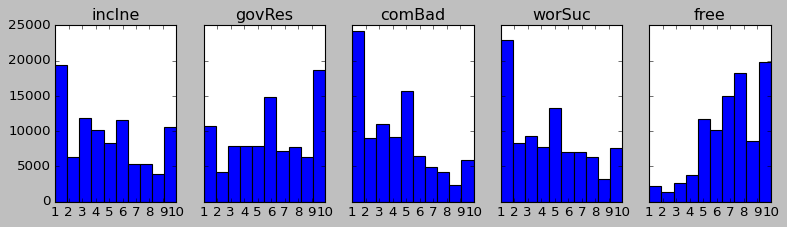

In [151]:
InteractiveShell.ast_node_interactivity = 'none' #surpress loop output

a=wvs[['incIne', 'govRes', 'comBad', 'worSuc', 'free']]
fig, ax = plt.subplots(1,5,sharey=True,tight_layout=True ,figsize = (10, 3))
for i,d in enumerate(a):
  ax[i].hist(a[d])
  ax[i].set_title(d)

interesting distributions, even free has a bump at lower end 1 (higher than 2 and about as high as 3); others more extreme bumps at each end, ppl seem to
undertand these as either or q

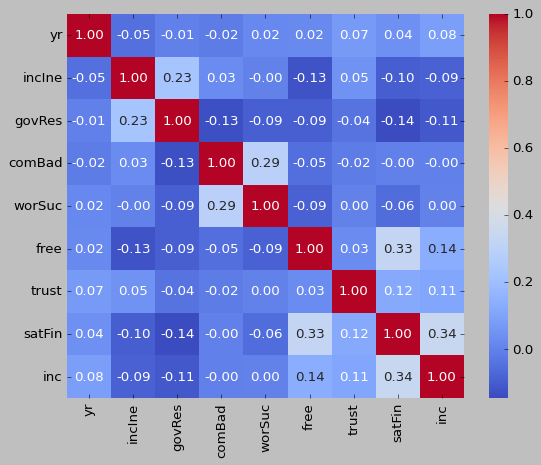

In [152]:
corr = wvs.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

not much relationship here among welfare/redistribution vars, but satFin with free at .33 so totally elaborate in regressions be creful in speficiations

and can get extra nuance with density heatmap below, just 2 vars for now, can do more later

In [153]:
InteractiveShell.ast_node_interactivity = 'all'

px.density_heatmap(wvs, x="free", y="govRes", marginal_x="histogram", marginal_y="histogram")

this is super interesting--huge cluster on free=10 with govRes=10 but also with govRes=0

fut res: id these ppl! religious? extremist? etc

# c lev vis

## wvs only initial playing
TODO really take these ideas into next sec c: merged wvs+wdi

In [154]:
wvsC

,yr,incIne,govRes,comBad,worSuc,free,trust,satFin,inc
cc,,,,,,,,,
AND,2018.0,4.86,6.53,3.13,4.58,7.52,0.26,6.56,5.36
ARG,2017.0,5.43,5.98,4.74,4.69,7.77,0.21,5.99,5.08
ARM,2021.0,2.05,6.82,2.96,4.08,7.77,0.08,5.27,4.70
AUS,2018.0,5.00,5.66,3.58,4.24,7.67,0.54,6.68,5.13
BGD,2018.0,7.04,6.74,3.44,3.35,7.27,0.13,6.99,5.62
...,...,...,...,...,...,...,...,...,...
URY,2022.0,4.80,5.58,4.38,5.29,8.29,0.15,6.90,5.01
USA,2017.0,6.07,5.43,3.23,3.77,7.71,0.40,6.09,5.05
VEN,2021.0,3.84,4.86,5.15,5.00,7.73,0.14,4.89,4.48


countries that are low on govRes are failed states or authritarian states like IRQ, NIC, VEN, but also individualistic/capitalistic like USA, HKG

trust is low in lat am like BRA, COL, MEX; and high surprisingly in CHN, and classic ones like NLD, CAN, GBR

In [155]:
wvsC.style.background_gradient(cmap='RdYlGn').format(precision=2)

,yr,incIne,govRes,comBad,worSuc,free,trust,satFin,inc
cc,,,,,,,,,
AND,2018.00,4.86,6.53,3.13,4.58,7.52,0.26,6.56,5.36
ARG,2017.00,5.43,5.98,4.74,4.69,7.77,0.21,5.99,5.08
ARM,2021.00,2.05,6.82,2.96,4.08,7.77,0.08,5.27,4.70
AUS,2018.00,5.00,5.66,3.58,4.24,7.67,0.54,6.68,5.13
BGD,2018.00,7.04,6.74,3.44,3.35,7.27,0.13,6.99,5.62
BOL,2017.00,4.57,5.26,5.05,4.38,7.48,0.09,6.45,5.01
BRA,2018.00,5.92,7.45,3.77,4.64,7.56,0.07,6.07,4.02
CAN,2020.00,5.46,5.47,4.18,4.91,7.43,0.50,6.52,5.57
CHL,2018.00,7.06,6.57,4.62,4.69,7.49,0.14,6.15,4.68


<Figure size 960x800 with 0 Axes>

<Axes: xlabel='govRes', ylabel='cc'>

Text(0.5, 1.0, 'Government Regulation (govRes) by Country and Continent')

Text(0.5, 0, 'Government Regulation Score')

Text(0, 0.5, 'Country Code')

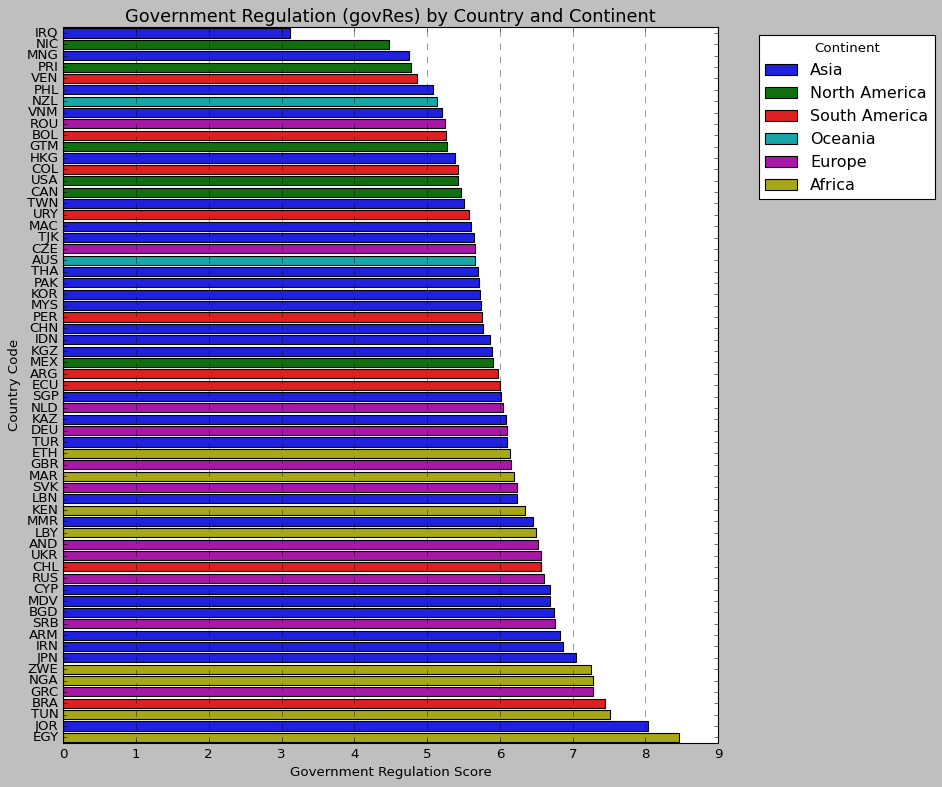

In [156]:
#make a horizontal bar chart of govRes by cc ordering on govRes and color code bars with different colors for different continents for countries defined with 3 letter codes in cc variable
#note in WDI there are groups of countries like rich poor and continents too
try:
    import pycountry_convert as pc
except ImportError:
    !pip install pycountry-convert
    import pycountry_convert as pc

def country_code_to_continent(country_code):
    try:
        cn_alpha2 = pc.country_alpha3_to_country_alpha2(country_code)
        cn_continent = pc.country_alpha2_to_continent_code(cn_alpha2)
        return pc.convert_continent_code_to_continent_name(cn_continent)
    except KeyError:
        return np.nan

# Create a new 'continent' column based on the 'cc' index
wvsC_plot = wvsC.copy()
wvsC_plot['continent'] = wvsC_plot.index.map(country_code_to_continent)

# Filter out countries where continent could not be determined
wvsC_plot = wvsC_plot.dropna(subset=['continent'])

# Sort by 'govRes' for ordering the bars
wvsC_plot = wvsC_plot.sort_values('govRes', ascending=True)

# Create the horizontal bar chart
plt.figure(figsize=(12, 10))
sns.barplot(
    x='govRes',
    y=wvsC_plot.index,
    hue='continent',
    data=wvsC_plot,
    dodge=False
)

plt.title('Government Regulation (govRes) by Country and Continent', fontsize=16)
plt.xlabel('Government Regulation Score', fontsize=12)
plt.ylabel('Country Code', fontsize=12)
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

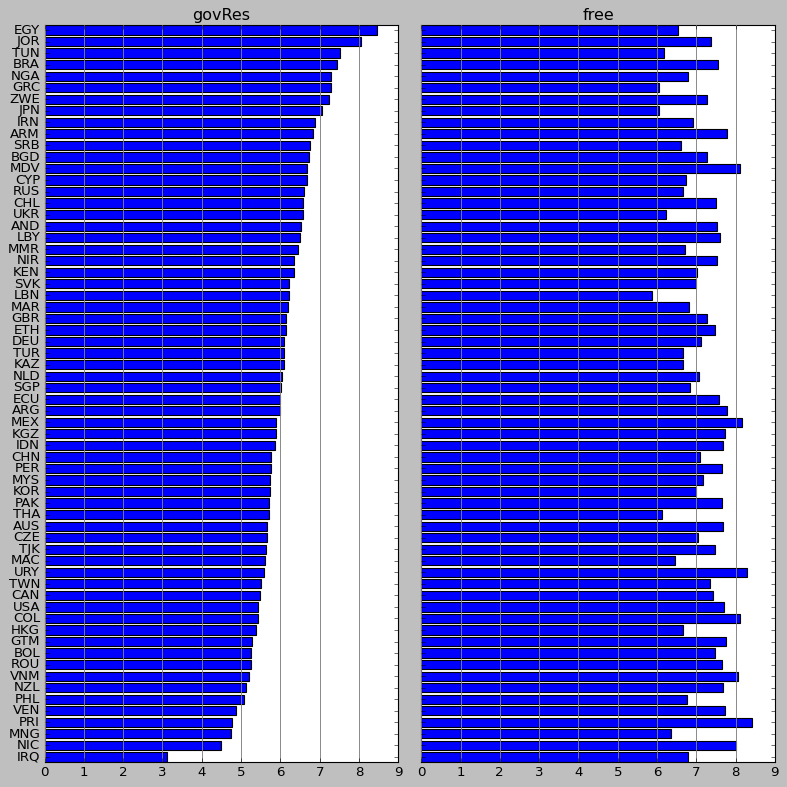

In [157]:
wvsC=wvsC.sort_values(['govRes', 'free'], ascending=[True, True])
fig, axs = plt.subplots(1, 2, figsize = (10, 10), sharey=True, tight_layout=True,
    gridspec_kw={'width_ratios': [1,1]})
axs[0].barh(wvsC.index,wvsC.govRes)
axs[0].set_title('govRes')
axs[1].barh(wvsC.index,wvsC.free)
axs[1].set_title('free')
axs[0].grid(axis='x' , color ='grey', linestyle ='-', linewidth = 0.9,alpha = 0.9)
axs[1].grid(axis='x' , color ='grey', linestyle ='-', linewidth = 0.9,alpha = 0.9);

In [158]:
wvsC.index


Index(['IRQ', 'NIC', 'MNG', 'PRI', 'VEN', 'PHL', 'NZL', 'VNM', 'ROU', 'BOL',
       'GTM', 'HKG', 'COL', 'USA', 'CAN', 'TWN', 'URY', 'MAC', 'TJK', 'CZE',
       'AUS', 'THA', 'PAK', 'KOR', 'MYS', 'PER', 'CHN', 'IDN', 'KGZ', 'MEX',
       'ARG', 'ECU', 'SGP', 'NLD', 'KAZ', 'TUR', 'DEU', 'ETH', 'GBR', 'MAR',
       'LBN', 'SVK', 'KEN', 'NIR', 'MMR', 'LBY', 'AND', 'UKR', 'CHL', 'RUS',
       'CYP', 'MDV', 'BGD', 'SRB', 'ARM', 'IRN', 'JPN', 'ZWE', 'GRC', 'NGA',
       'BRA', 'TUN', 'JOR', 'EGY'],
      dtype='object', name='cc')

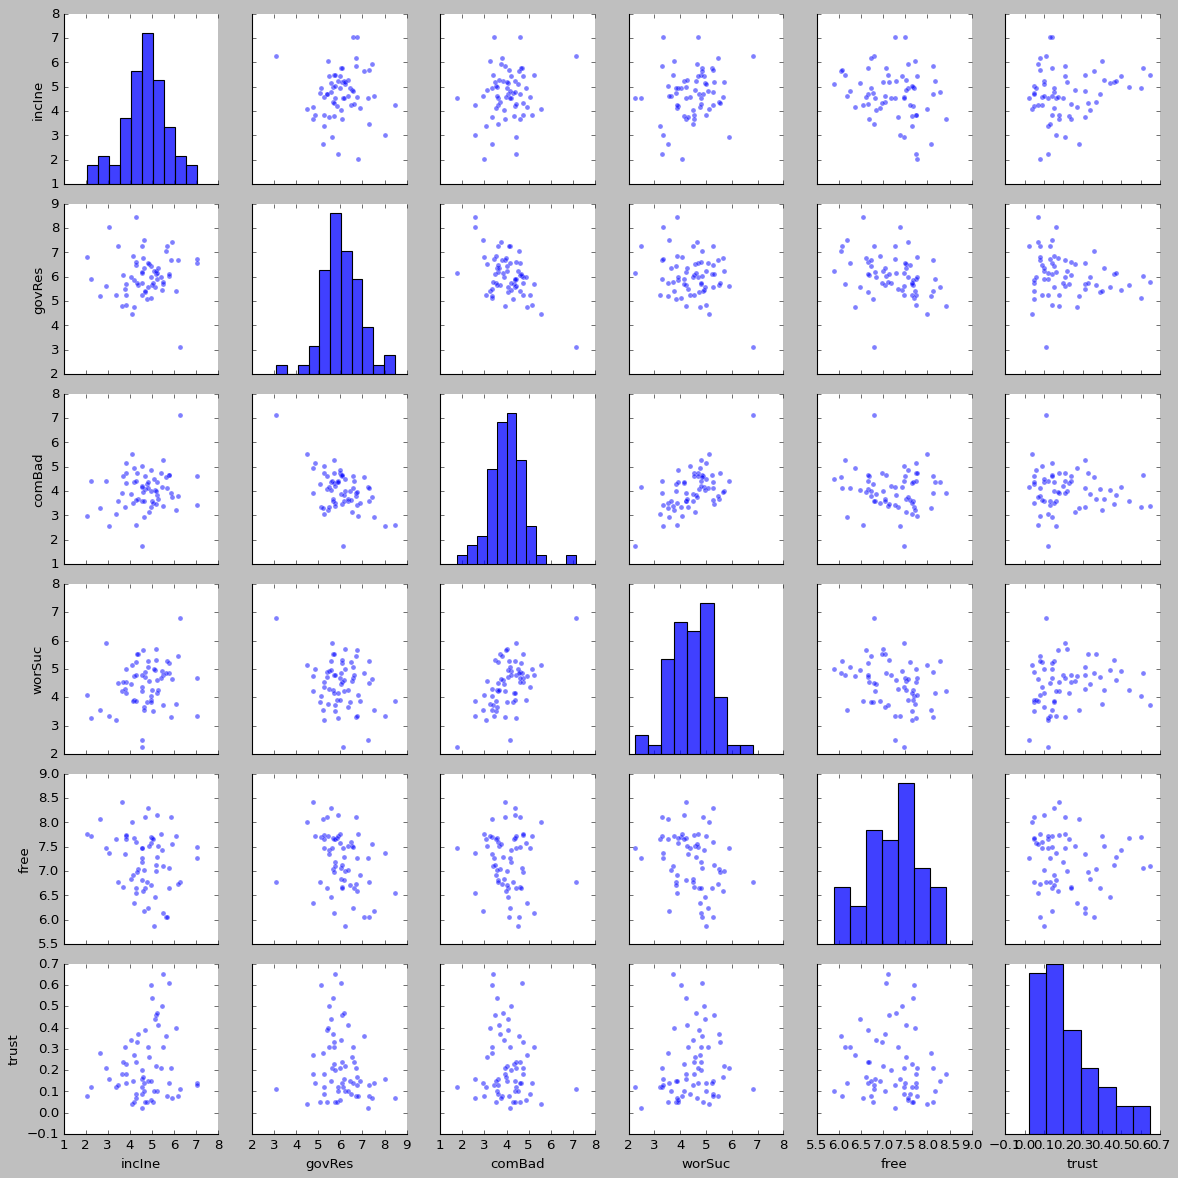

In [159]:
sns.pairplot(wvsC[['incIne', 'govRes', 'comBad', 'worSuc', 'free', 'trust']],
             kind='scatter', plot_kws={'alpha': 0.5},
             #hue='foreign'
             )

/tmp/ipython-input-1423781929.py:14: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



([Text(3.2510887096774193, 4.6239453125, 'AND'),
  Text(4.814092741935484, 4.766171875, 'ARG'),
  Text(3.0834173387096775, 4.123945312499999, 'ARM'),
  Text(3.615282258064516, 4.3249609375, 'AUS'),
  Text(3.560425403225806, 3.3207031249999996, 'BGD'),
  Text(5.160997983870968, 4.4239453125, 'BOL'),
  Text(3.781290322580645, 4.798203124999999, 'BRA'),
  Text(4.37758064516129, 5.018046875000001, 'CAN'),
  Text(4.833104838709677, 4.625546875, 'CHL'),
  Text(3.495574596774194, 3.6930859375000002, 'CHN'),
  Text(4.640564516129032, 4.924101562500002, 'COL'),
  Text(3.9158467741935485, 5.420703124999999, 'CYP'),
  Text(3.7990887096774193, 5.597890624999999, 'CZE'),
  Text(3.5575564516129035, 5.397890624999999, 'DEU'),
  Text(4.974102822580645, 3.9439453124999995, 'ECU'),
  Text(2.6978931451612898, 3.9239453125, 'EGY'),
  Text(1.8694455645161288, 2.3039453125, 'ETH'),
  Text(3.9905443548387094, 4.639296874999999, 'GBR'),
  Text(4.231227822580645, 5.357890624999999, 'GRC'),
  Text(4.93911290322

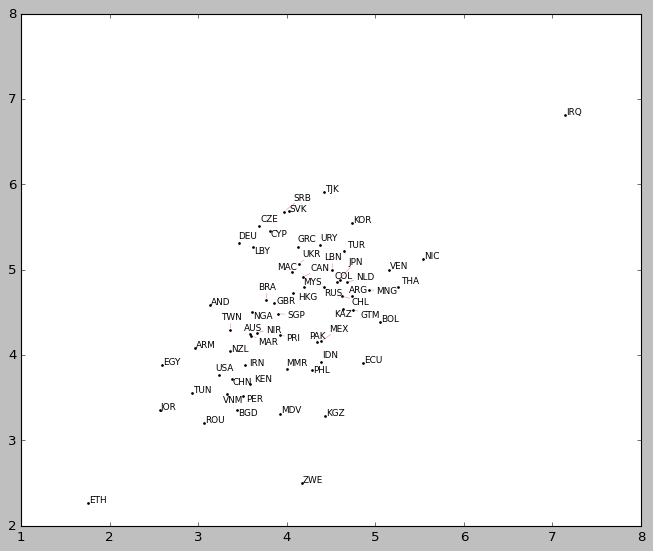

In [160]:
!pip install adjustText
from adjustText import adjust_text
fig, ax = plt.subplots(figsize=(10,8))
wvsC=wvsC.sort_index()
#auto[['make','weight','mpg']].info()

ax.scatter(wvsC['comBad'],wvsC['worSuc'],s=2)
#before adj text need to make a list of labels to feed into adjust_text function
#sth like this with loop and append, but the format not right for the adjust_text
#texts=[]
#for i, txt in enumerate(auto['make']):
#    texts.append([txt, (auto['weight'][i],auto['mpg'][i])])
#this works as list comprehension
texts = [plt.text(wvsC['comBad'][i],wvsC['worSuc'][i], wvsC.index[i],fontsize=8) for i in range(len(wvsC))]
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red', alpha=.5,lw=.5)) #and there's ton of options to tweak it more

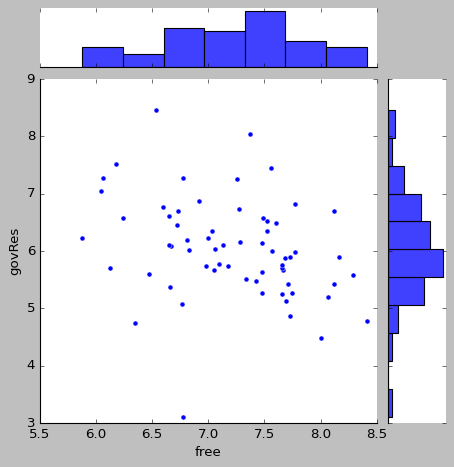

In [161]:
sns.jointplot(x ='free', y ='govRes', data = wvsC)

<Figure size 960x800 with 0 Axes>

/tmp/ipython-input-589719593.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 5, 'AND')

Text(0, 5, 'ARG')

Text(0, 5, 'ARM')

Text(0, 5, 'AUS')

Text(0, 5, 'BGD')

Text(0, 5, 'BOL')

Text(0, 5, 'BRA')

Text(0, 5, 'CAN')

Text(0, 5, 'CHL')

Text(0, 5, 'CHN')

Text(0, 5, 'COL')

Text(0, 5, 'CYP')

Text(0, 5, 'CZE')

Text(0, 5, 'DEU')

Text(0, 5, 'ECU')

Text(0, 5, 'EGY')

Text(0, 5, 'ETH')

Text(0, 5, 'GBR')

Text(0, 5, 'GRC')

Text(0, 5, 'GTM')

Text(0, 5, 'HKG')

Text(0, 5, 'IDN')

Text(0, 5, 'IRN')

Text(0, 5, 'IRQ')

Text(0, 5, 'JOR')

Text(0, 5, 'JPN')

Text(0, 5, 'KAZ')

Text(0, 5, 'KEN')

Text(0, 5, 'KGZ')

Text(0, 5, 'KOR')

Text(0, 5, 'LBN')

Text(0, 5, 'LBY')

Text(0, 5, 'MAC')

Text(0, 5, 'MAR')

Text(0, 5, 'MDV')

Text(0, 5, 'MEX')

Text(0, 5, 'MMR')

Text(0, 5, 'MNG')

Text(0, 5, 'MYS')

Text(0, 5, 'NGA')

Text(0, 5, 'NIC')

Text(0, 5, 'NIR')

Text(0, 5, 'NLD')

Text(0, 5, 'NZL')

Text(0, 5, 'PAK')

Text(0, 5, 'PER')

Text(0, 5, 'PHL')

Text(0, 5, 'PRI')

Text(0, 5, 'ROU')

Text(0, 5, 'RUS')

Text(0, 5, 'SGP')

Text(0, 5, 'SRB')

Text(0, 5, 'SVK')

Text(0, 5, 'THA')

Text(0, 5, 'TJK')

Text(0, 5, 'TUN')

Text(0, 5, 'TUR')

Text(0, 5, 'TWN')

Text(0, 5, 'UKR')

Text(0, 5, 'URY')

Text(0, 5, 'USA')

Text(0, 5, 'VEN')

Text(0, 5, 'VNM')

Text(0, 5, 'ZWE')

Text(0.5, 1.0, 'Government Regulation vs. Freedom with Country Labels (Small and Centered)')

Text(0.5, 0, 'Freedom (free)')

Text(0, 0.5, 'Government Regulation (govRes)')

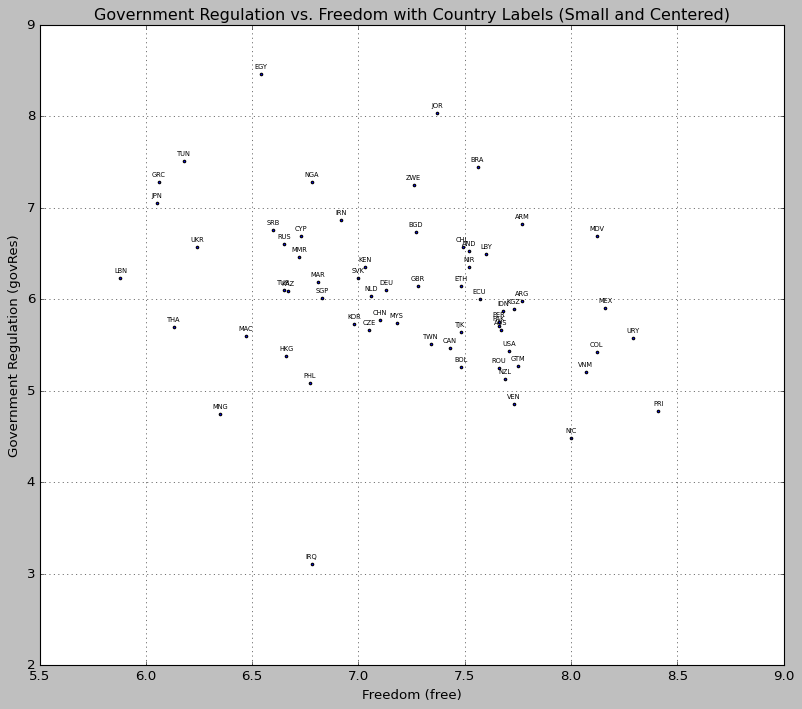

In [162]:
plt.figure(figsize=(12, 10))
plt.scatter(wvsC['free'], wvsC['govRes'], s=5) # s for marker size

# Add labels to each point with smaller font size and centered on top
for i, cc in enumerate(wvsC.index):
    plt.annotate(cc, (wvsC['free'][i], wvsC['govRes'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6) # xytext=(0,5) moves label 5 points up, ha='center' centers it, fontsize=6 makes it small

plt.title('Government Regulation vs. Freedom with Country Labels (Small and Centered)')
plt.xlabel('Freedom (free)')
plt.ylabel('Government Regulation (govRes)')
plt.grid(True)
plt.show()

<Figure size 960x800 with 0 Axes>

/tmp/ipython-input-589719593.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 5, 'AND')

Text(0, 5, 'ARG')

Text(0, 5, 'ARM')

Text(0, 5, 'AUS')

Text(0, 5, 'BGD')

Text(0, 5, 'BOL')

Text(0, 5, 'BRA')

Text(0, 5, 'CAN')

Text(0, 5, 'CHL')

Text(0, 5, 'CHN')

Text(0, 5, 'COL')

Text(0, 5, 'CYP')

Text(0, 5, 'CZE')

Text(0, 5, 'DEU')

Text(0, 5, 'ECU')

Text(0, 5, 'EGY')

Text(0, 5, 'ETH')

Text(0, 5, 'GBR')

Text(0, 5, 'GRC')

Text(0, 5, 'GTM')

Text(0, 5, 'HKG')

Text(0, 5, 'IDN')

Text(0, 5, 'IRN')

Text(0, 5, 'IRQ')

Text(0, 5, 'JOR')

Text(0, 5, 'JPN')

Text(0, 5, 'KAZ')

Text(0, 5, 'KEN')

Text(0, 5, 'KGZ')

Text(0, 5, 'KOR')

Text(0, 5, 'LBN')

Text(0, 5, 'LBY')

Text(0, 5, 'MAC')

Text(0, 5, 'MAR')

Text(0, 5, 'MDV')

Text(0, 5, 'MEX')

Text(0, 5, 'MMR')

Text(0, 5, 'MNG')

Text(0, 5, 'MYS')

Text(0, 5, 'NGA')

Text(0, 5, 'NIC')

Text(0, 5, 'NIR')

Text(0, 5, 'NLD')

Text(0, 5, 'NZL')

Text(0, 5, 'PAK')

Text(0, 5, 'PER')

Text(0, 5, 'PHL')

Text(0, 5, 'PRI')

Text(0, 5, 'ROU')

Text(0, 5, 'RUS')

Text(0, 5, 'SGP')

Text(0, 5, 'SRB')

Text(0, 5, 'SVK')

Text(0, 5, 'THA')

Text(0, 5, 'TJK')

Text(0, 5, 'TUN')

Text(0, 5, 'TUR')

Text(0, 5, 'TWN')

Text(0, 5, 'UKR')

Text(0, 5, 'URY')

Text(0, 5, 'USA')

Text(0, 5, 'VEN')

Text(0, 5, 'VNM')

Text(0, 5, 'ZWE')

Text(0.5, 1.0, 'Government Regulation vs. Freedom with Country Labels (Small and Centered)')

Text(0.5, 0, 'Freedom (free)')

Text(0, 0.5, 'Government Regulation (govRes)')

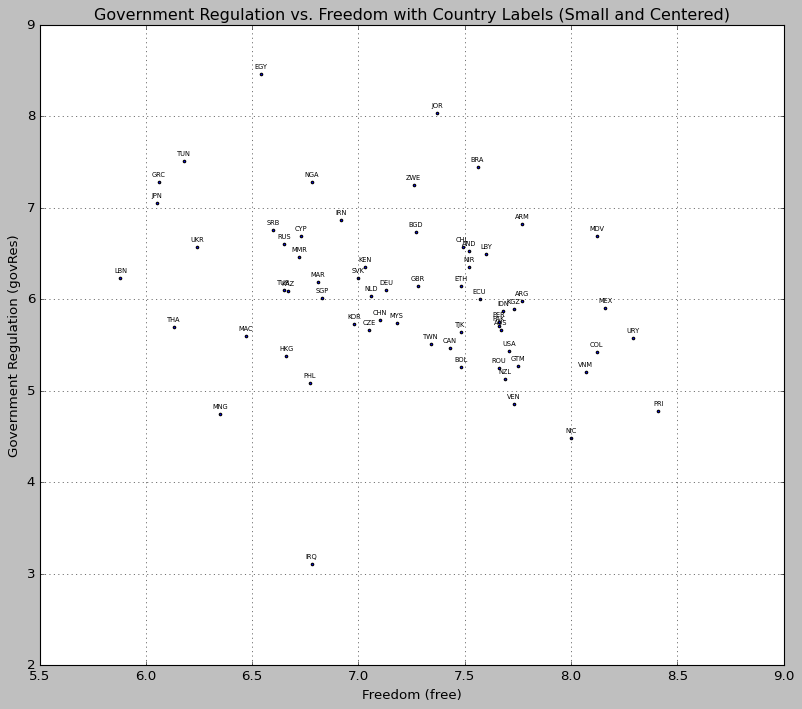

In [163]:
plt.figure(figsize=(12, 10))
plt.scatter(wvsC['free'], wvsC['govRes'], s=5) # s for marker size

# Add labels to each point with smaller font size and centered on top
for i, cc in enumerate(wvsC.index):
    plt.annotate(cc, (wvsC['free'][i], wvsC['govRes'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6) # xytext=(0,5) moves label 5 points up, ha='center' centers it, fontsize=6 makes it small

plt.title('Government Regulation vs. Freedom with Country Labels (Small and Centered)')
plt.xlabel('Freedom (free)')
plt.ylabel('Government Regulation (govRes)')
plt.grid(True)
plt.show()

<Figure size 960x800 with 0 Axes>

/tmp/ipython-input-2497016259.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 5, 'AND')

Text(0, 5, 'ARG')

Text(0, 5, 'ARM')

Text(0, 5, 'AUS')

Text(0, 5, 'BGD')

Text(0, 5, 'BOL')

Text(0, 5, 'BRA')

Text(0, 5, 'CAN')

Text(0, 5, 'CHL')

Text(0, 5, 'CHN')

Text(0, 5, 'COL')

Text(0, 5, 'CYP')

Text(0, 5, 'CZE')

Text(0, 5, 'DEU')

Text(0, 5, 'ECU')

Text(0, 5, 'EGY')

Text(0, 5, 'ETH')

Text(0, 5, 'GBR')

Text(0, 5, 'GRC')

Text(0, 5, 'GTM')

Text(0, 5, 'HKG')

Text(0, 5, 'IDN')

Text(0, 5, 'IRN')

Text(0, 5, 'IRQ')

Text(0, 5, 'JOR')

Text(0, 5, 'JPN')

Text(0, 5, 'KAZ')

Text(0, 5, 'KEN')

Text(0, 5, 'KGZ')

Text(0, 5, 'KOR')

Text(0, 5, 'LBN')

Text(0, 5, 'LBY')

Text(0, 5, 'MAC')

Text(0, 5, 'MAR')

Text(0, 5, 'MDV')

Text(0, 5, 'MEX')

Text(0, 5, 'MMR')

Text(0, 5, 'MNG')

Text(0, 5, 'MYS')

Text(0, 5, 'NGA')

Text(0, 5, 'NIC')

Text(0, 5, 'NIR')

Text(0, 5, 'NLD')

Text(0, 5, 'NZL')

Text(0, 5, 'PAK')

Text(0, 5, 'PER')

Text(0, 5, 'PHL')

Text(0, 5, 'PRI')

Text(0, 5, 'ROU')

Text(0, 5, 'RUS')

Text(0, 5, 'SGP')

Text(0, 5, 'SRB')

Text(0, 5, 'SVK')

Text(0, 5, 'THA')

Text(0, 5, 'TJK')

Text(0, 5, 'TUN')

Text(0, 5, 'TUR')

Text(0, 5, 'TWN')

Text(0, 5, 'UKR')

Text(0, 5, 'URY')

Text(0, 5, 'USA')

Text(0, 5, 'VEN')

Text(0, 5, 'VNM')

Text(0, 5, 'ZWE')

Text(0.5, 1.0, 'Government Regulation vs. Freedom with Country Labels (Small Points and Labels)')

Text(0.5, 0, 'Freedom (free)')

Text(0, 0.5, 'Government Regulation (govRes)')

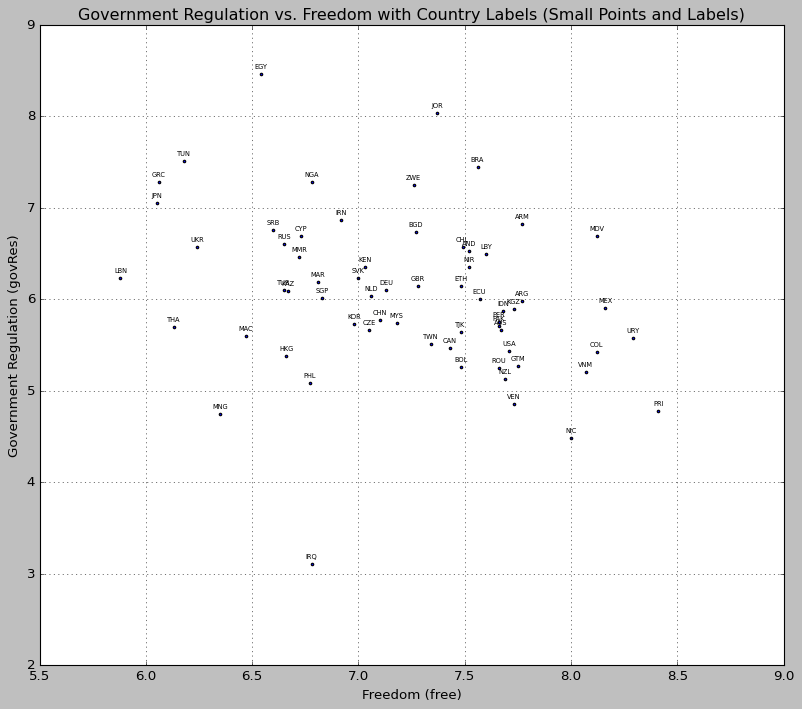

In [164]:
plt.figure(figsize=(12, 10))
plt.scatter(wvsC['free'], wvsC['govRes'], s=5) # s for marker size

# Add labels to each point with smaller font size
for i, cc in enumerate(wvsC.index):
    plt.annotate(cc, (wvsC['free'][i], wvsC['govRes'][i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6) # fontsize for label size

plt.title('Government Regulation vs. Freedom with Country Labels (Small Points and Labels)')
plt.xlabel('Freedom (free)')
plt.ylabel('Government Regulation (govRes)')
plt.grid(True)
plt.show()

<Figure size 960x800 with 0 Axes>

/tmp/ipython-input-2671957532.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 10, 'AND')

Text(0, 10, 'ARG')

Text(0, 10, 'ARM')

Text(0, 10, 'AUS')

Text(0, 10, 'BGD')

Text(0, 10, 'BOL')

Text(0, 10, 'BRA')

Text(0, 10, 'CAN')

Text(0, 10, 'CHL')

Text(0, 10, 'CHN')

Text(0, 10, 'COL')

Text(0, 10, 'CYP')

Text(0, 10, 'CZE')

Text(0, 10, 'DEU')

Text(0, 10, 'ECU')

Text(0, 10, 'EGY')

Text(0, 10, 'ETH')

Text(0, 10, 'GBR')

Text(0, 10, 'GRC')

Text(0, 10, 'GTM')

Text(0, 10, 'HKG')

Text(0, 10, 'IDN')

Text(0, 10, 'IRN')

Text(0, 10, 'IRQ')

Text(0, 10, 'JOR')

Text(0, 10, 'JPN')

Text(0, 10, 'KAZ')

Text(0, 10, 'KEN')

Text(0, 10, 'KGZ')

Text(0, 10, 'KOR')

Text(0, 10, 'LBN')

Text(0, 10, 'LBY')

Text(0, 10, 'MAC')

Text(0, 10, 'MAR')

Text(0, 10, 'MDV')

Text(0, 10, 'MEX')

Text(0, 10, 'MMR')

Text(0, 10, 'MNG')

Text(0, 10, 'MYS')

Text(0, 10, 'NGA')

Text(0, 10, 'NIC')

Text(0, 10, 'NIR')

Text(0, 10, 'NLD')

Text(0, 10, 'NZL')

Text(0, 10, 'PAK')

Text(0, 10, 'PER')

Text(0, 10, 'PHL')

Text(0, 10, 'PRI')

Text(0, 10, 'ROU')

Text(0, 10, 'RUS')

Text(0, 10, 'SGP')

Text(0, 10, 'SRB')

Text(0, 10, 'SVK')

Text(0, 10, 'THA')

Text(0, 10, 'TJK')

Text(0, 10, 'TUN')

Text(0, 10, 'TUR')

Text(0, 10, 'TWN')

Text(0, 10, 'UKR')

Text(0, 10, 'URY')

Text(0, 10, 'USA')

Text(0, 10, 'VEN')

Text(0, 10, 'VNM')

Text(0, 10, 'ZWE')

Text(0.5, 1.0, 'Government Regulation vs. Freedom with Country Labels')

Text(0.5, 0, 'Freedom (free)')

Text(0, 0.5, 'Government Regulation (govRes)')

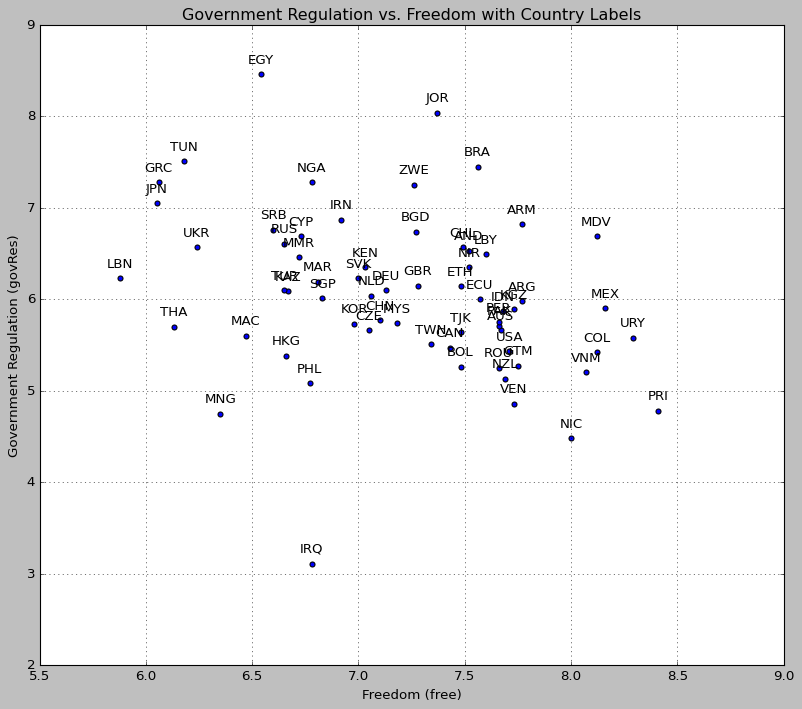

In [165]:
plt.figure(figsize=(12, 10))
plt.scatter(wvsC['free'], wvsC['govRes'])

# Add labels to each point
for i, cc in enumerate(wvsC.index):
    plt.annotate(cc, (wvsC['free'][i], wvsC['govRes'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Government Regulation vs. Freedom with Country Labels')
plt.xlabel('Freedom (free)')
plt.ylabel('Government Regulation (govRes)')
plt.grid(True)
plt.show()

<Figure size 960x800 with 0 Axes>

/tmp/ipython-input-3257849675.py:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0, 10, 'AND')

Text(0, 10, 'ARG')

Text(0, 10, 'ARM')

Text(0, 10, 'AUS')

Text(0, 10, 'BGD')

Text(0, 10, 'BOL')

Text(0, 10, 'BRA')

Text(0, 10, 'CAN')

Text(0, 10, 'CHL')

Text(0, 10, 'CHN')

Text(0, 10, 'COL')

Text(0, 10, 'CYP')

Text(0, 10, 'CZE')

Text(0, 10, 'DEU')

Text(0, 10, 'ECU')

Text(0, 10, 'EGY')

Text(0, 10, 'ETH')

Text(0, 10, 'GBR')

Text(0, 10, 'GRC')

Text(0, 10, 'GTM')

Text(0, 10, 'HKG')

Text(0, 10, 'IDN')

Text(0, 10, 'IRN')

Text(0, 10, 'IRQ')

Text(0, 10, 'JOR')

Text(0, 10, 'JPN')

Text(0, 10, 'KAZ')

Text(0, 10, 'KEN')

Text(0, 10, 'KGZ')

Text(0, 10, 'KOR')

Text(0, 10, 'LBN')

Text(0, 10, 'LBY')

Text(0, 10, 'MAC')

Text(0, 10, 'MAR')

Text(0, 10, 'MDV')

Text(0, 10, 'MEX')

Text(0, 10, 'MMR')

Text(0, 10, 'MNG')

Text(0, 10, 'MYS')

Text(0, 10, 'NGA')

Text(0, 10, 'NIC')

Text(0, 10, 'NIR')

Text(0, 10, 'NLD')

Text(0, 10, 'NZL')

Text(0, 10, 'PAK')

Text(0, 10, 'PER')

Text(0, 10, 'PHL')

Text(0, 10, 'PRI')

Text(0, 10, 'ROU')

Text(0, 10, 'RUS')

Text(0, 10, 'SGP')

Text(0, 10, 'SRB')

Text(0, 10, 'SVK')

Text(0, 10, 'THA')

Text(0, 10, 'TJK')

Text(0, 10, 'TUN')

Text(0, 10, 'TUR')

Text(0, 10, 'TWN')

Text(0, 10, 'UKR')

Text(0, 10, 'URY')

Text(0, 10, 'USA')

Text(0, 10, 'VEN')

Text(0, 10, 'VNM')

Text(0, 10, 'ZWE')

Text(0.5, 1.0, 'Freedom vs. Government Regulation with Country Labels')

Text(0.5, 0, 'Government Regulation (govRes)')

Text(0, 0.5, 'Freedom (free)')

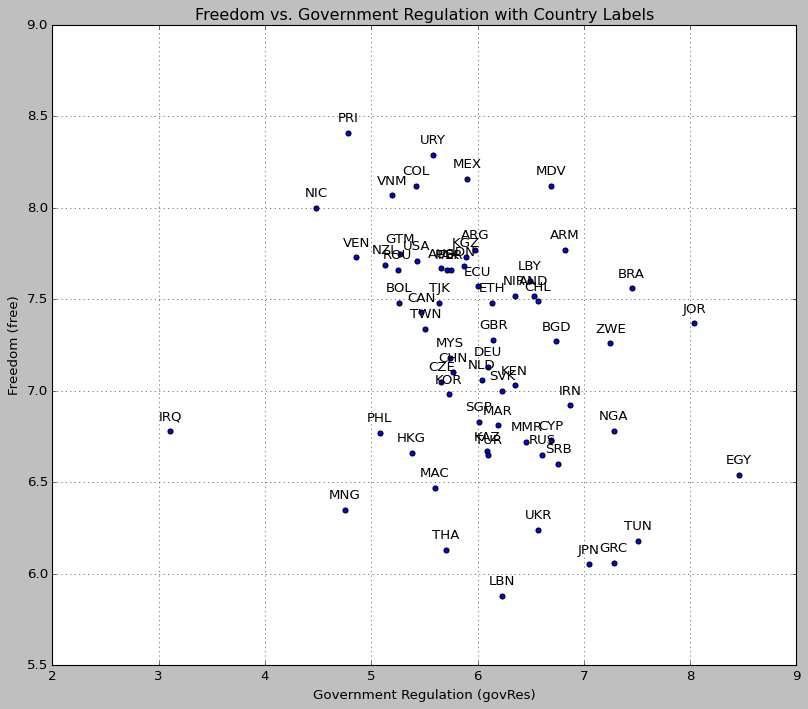

In [166]:
plt.figure(figsize=(12, 10))
plt.scatter(wvsC['govRes'], wvsC['free'])

# Add labels to each point
for i, cc in enumerate(wvsC.index):
    plt.annotate(cc, (wvsC['govRes'][i], wvsC['free'][i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Freedom vs. Government Regulation with Country Labels')
plt.xlabel('Government Regulation (govRes)')
plt.ylabel('Freedom (free)')
plt.grid(True)
plt.show()

<Figure size 800x560 with 0 Axes>

Text(0.5, 1.0, 'Freedom vs. Government Regulation')

Text(0.5, 0, 'Government Regulation (govRes)')

Text(0, 0.5, 'Freedom (free)')

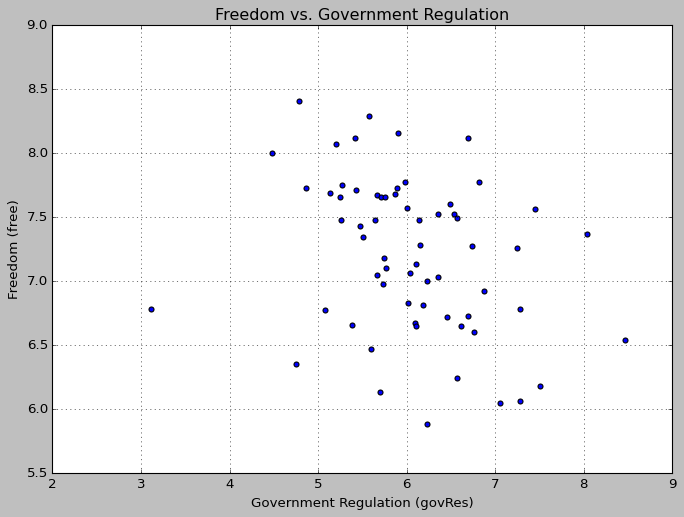

In [167]:
plt.figure(figsize=(10, 7))
plt.scatter(wvsC['govRes'], wvsC['free'])
plt.title('Freedom vs. Government Regulation')
plt.xlabel('Government Regulation (govRes)')
plt.ylabel('Freedom (free)')
plt.grid(True)
plt.show()

## c: merged wvs+wdi

In [168]:
c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 87.0 to 265.0
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   yr               64 non-null     float64 
 1   incIne           64 non-null     float64 
 2   govRes           64 non-null     float64 
 3   comBad           64 non-null     float64 
 4   worSuc           64 non-null     float64 
 5   free             64 non-null     float64 
 6   trust            64 non-null     float64 
 7   satFin           64 non-null     float64 
 8   inc              64 non-null     float64 
 9   countrycode      64 non-null     object  
 10  countryname      62 non-null     object  
 11  regionname       62 non-null     object  
 12  incomelevelname  62 non-null     object  
 13  si_pov_nahc      47 non-null     float32 
 14  ny_gdp_pcap_kd   62 non-null     float32 
 15  si_dst_10th_10   51 non-null     float32 
 16  _merge           64 non-null     category
dty

In [169]:
c['ny_gdp_pcap_kd'].corr(c['free']) #ha! freedom/autonomy has nothing to do with pcgdp!!
#top: lat am; right capiatlism, etc could circle later like welzel-inglehart maps
px.scatter(c, x='ny_gdp_pcap_kd', y='free', hover_data=['countrycode','countryname'])

np.float64(-0.0336361755367821)

In [37]:
c['si_dst_10th_10'].corr(c['free']) #wow more ineq more freedom/autonomy!
px.scatter(c, x='si_dst_10th_10', y='free', hover_data=['countrycode','countryname'])
#top right: mex col bra unequal but free!

np.float64(0.3842841109023618)

In [38]:
c['si_pov_nahc'].corr(c['free']) #wow more pov more freedom/autonomy!
px.scatter(c, x='si_pov_nahc', y='free', hover_data=['countrycode','countryname'])

np.float64(0.16833992048258792)

weird to think that more pov and ineq would produce more freedom/autonomy; rather i guess lax capitalist friendly regulation would produce more pov and inequality, but should alsop produce less autonomy/freedom on avg

or maybe more freedom/autonomy more pov and ineq?

#  sandbox